# Generative Pre-trained Transformer

## Problem 4: Self-attention

In this exercise we train a small GPT model to generate text as written by William Shakespeare.

### Import Python modul

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline

### Initialize parameters for neural network model

In [2]:
batch_size = 32      # how many independent sequences will we process in parallel?
block_size = 8       # maximum sequence length considere for learning the model?
n_embd = 32          # dimension of the embedding of the input tokens (also chosen as head size)
n_head = 0           # number of heads
n_layer = 1          # number of hidden layers (blocks)
dropout = 0.0        # Regularization to avoid overfitting: drop out probability

### Initialize parameters for learning

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)              # Verify that GPU is used and the device is 'cuda' 

max_iters = 10000          # number of training iterations
learning_rate = 1e-3       
eval_interval = 500        # intervals at which the model performance is evaluated
eval_iters = 200           # number of iterations used to estimate the performance

cuda


### Set random seed

Needed for reproducibility of the results

In [4]:
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)

### Load data

Load raw text stored in the file `input.txt` containing  William Shakespeare's works. The dataset is originally taken from [this repository](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In [5]:
with open('data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

### Tokenizer

Simple character based tokenizer: Encoding and decoding of characters to tokens.

In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]           # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])  # decoder: take a list of integers, output a string

### Generate training and test splits

In [7]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))    # first 90% is training data, rest is validation data
train_data = data[:n]
val_data = data[n:]

### Define helper functions

Select `batch_size` text sequences of length `block_size` at random locations in the text and store the data in a matrix of size `batch_size`x`block_size`

In [8]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

Estimate the loss on both splits `train` and `val` by averaging the loss for `eval_iters` samples of data matrices generated by `get_batch`.

In [9]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### Neural network model

#### Self-attention model

Core mechanism of this exercise.

In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.register_buffer('prob', torch.zeros(block_size, block_size)) 
        self.register_buffer('k', torch.zeros(block_size, head_size)) 
        self.register_buffer('q', torch.zeros(block_size, head_size)) 
        self.register_buffer('v', torch.zeros(block_size, head_size)) 
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)

        # store only first batch for visualization later during sequence generation
        self.prob = wei[0,:,:]  
        self.k = k[0,:,:]  
        self.q = q[0,:,:]  
        self.v = v[0,:,:] 
        return out

Multiple heads are only used in the final simulation.

In [11]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

#### Standard feed-forward layer of a neural network with ReLU activation functions.

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

#### Definition of a total layer of the neural network model 
Containing a standard feed-forward layer, skip-layers, self-attention and normalization steps.

In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        if n_head>0: 
            head_size = n_embd // n_head
            self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        if n_head>0:
            x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

#### GPT model

In [14]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### Create a GPT model

In [15]:
model = GPTLanguageModel()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.017153 M parameters


#### Define loss and optimizer
For this classification problem we use the cross entropy error function
$$J = -\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^K y_{ik} \ln(q_{ik})$$
which is available in `pytorch` as `functional.cross_entropy` (see `GPTLanguageModel.forward`).

As optimizer we suggest to use `AdamW` - stochastic gradient-based optimization method. See the [arxive paper](https://arxiv.org/abs/1711.05101) for more details.

In [16]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Run training of the neural network

In [17]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.1705, val loss 4.1700
step 500: train loss 2.3534, val loss 2.3720
step 1000: train loss 2.2487, val loss 2.2615
step 1500: train loss 2.1677, val loss 2.1982
step 2000: train loss 2.1375, val loss 2.1700
step 2500: train loss 2.1093, val loss 2.1465
step 3000: train loss 2.0866, val loss 2.1341
step 3500: train loss 2.0768, val loss 2.1133
step 4000: train loss 2.0603, val loss 2.1201
step 4500: train loss 2.0468, val loss 2.1154
step 5000: train loss 2.0188, val loss 2.1264
step 5500: train loss 2.0350, val loss 2.1107
step 6000: train loss 2.0166, val loss 2.0872
step 6500: train loss 2.0055, val loss 2.1062
step 7000: train loss 1.9910, val loss 2.0918
step 7500: train loss 1.9858, val loss 2.0827
step 8000: train loss 1.9792, val loss 2.0953
step 8500: train loss 1.9807, val loss 2.0596
step 9000: train loss 1.9724, val loss 2.0671
step 9500: train loss 1.9652, val loss 2.0614
step 9999: train loss 1.9719, val loss 2.0893


### Simulate the GPT model for text generation

Define the initial text, i.e. the context.

In [18]:
context = """Lord:
Hence comes it that your kindred shuns your house,
As beaten hence by your strange lunacy.
O noble lord, bethink thee of thy birth,
Call home thy ancient thoughts from banishment
And """

Encode the text by the tokenizer, simulate the model for one step, decode and print the mode output.

You can run the following cell multiple times to generate a longer text sequence.

In [19]:
context = torch.tensor( encode(context) , dtype=torch.long, device=device)
context = decode(m.generate(context[None,:], max_new_tokens=1)[0].tolist())
print(context)

Lord:
Hence comes it that your kindred shuns your house,
As beaten hence by your strange lunacy.
O noble lord, bethink thee of thy birth,
Call home thy ancient thoughts from banishment
And t


### Explore the effect of self-attention on the performance

- Run the neural network without self-attention by setting `n_head = 0` to obtain a reference performance value.
- Run the neural network with self-attention and various values for `block_size = 2,4,8,16`.
- How does the `block_size' influence the training loss and the quality of the text generation? Why?
- Is there overfitting? Why or why not?
- Investigate the self-attention mechanism visualized below. Find context examples where self-attention matters.
 
- Set the network and learning parameters to the values below for the full GPT2 model and run a final text generation. Attention: 20 min learning time

(Optional)
- Run the full model with and without dropout and investigate the effect of the `dropout` propbability on the pe
rformance.

### Visualization of the self-attention mechanism 
(for `n_head = 1`)

Get key, queries and values of the self-attention mechanism for the last time step of the simulation in the cell above

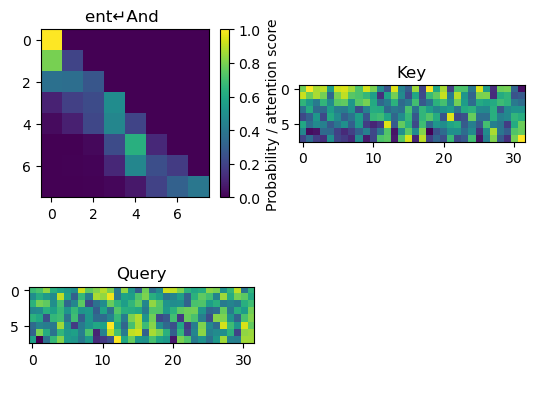

In [20]:
p = m.blocks[0].sa.heads[0].prob.detach().cpu().numpy()
k = m.blocks[0].sa.heads[0].k.detach().cpu().numpy()
q = m.blocks[0].sa.heads[0].q.detach().cpu().numpy()
v = m.blocks[0].sa.heads[0].v.detach().cpu().numpy()

fig, axs = plt.subplots(2,2)

ax=axs[0,0]
pi = ax.imshow(p)
ax.set_title(context[-block_size-1:-1].replace('\n','↵'))
fig.colorbar(pi,label="Probability / attention score") 

ax=axs[0,1]
ax.imshow(k)
ax.set_title('Key')

ax=axs[1,0]
ax.imshow(q)
ax.set_title('Query')

ax=axs[1,1]
ax.set_axis_off()

### Parameters for the final run

In [21]:
batch_size = 64 
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
out = 0.2